# Preparando as lições para o treinamento por aprendizado de máquina

Nesse notebook, a partir de parametros estabelecidos, as lições serão preparadas para então ser realizado o treinamento, para então serem realizadas as validações e inferências do modelo para detecção de faixas de pedestre.

## Selecionando as quadrículas SCM das licoes

In [1]:
import geopandas as gpd
import pandas as pd

In [2]:
gdf_scm = gpd.read_file('zip://downloads/SIRGAS_SHP_quadriculaortofoto2017.zip!/SIRGAS_SHP_quadriculaortofoto2017/SIRGAS_SHP_quadriculaortofoto2017.shp')

In [3]:
scm_licoes = pd.read_csv('downloads/imagens/SCMs-licoes.csv')

In [4]:
# scm_licoes.loc[scm_licoes["presente"] == 1]
licoes_utilizadas = scm_licoes.loc[scm_licoes["presente"] == 1, 'scm']

In [5]:
gdf_scm[gdf_scm['qo2010_cod'].isin(licoes_utilizadas)]

,qo2010_cod,geometry
2479,3314-311,"POLYGON ((327777.044 7392618.571, 327770.250 7..."
2480,3313-432,"POLYGON ((327245.386 7392612.299, 327238.571 7..."
2484,3313-412,"POLYGON ((325118.743 7392587.016, 325111.845 7..."
2561,3313-414,"POLYGON ((325125.643 7392010.236, 325118.743 7..."
2793,3316-221,"POLYGON ((332056.790 7390360.987, 332050.159 7..."
2807,3315-211,"POLYGON ((324614.772 7390273.522, 324607.847 7..."
2808,3315-132,"POLYGON ((324083.192 7390267.129, 324076.246 7..."
3035,3325-164,"POLYGON ((336860.179 7388684.936, 336853.733 7..."
3117,3325-332,"POLYGON ((336866.626 7388108.176, 336860.179 7..."
3179,3326-424,"POLYGON ((345376.197 7387624.020, 345370.085 7..."


## Gerando as Labels de faixas de pedestre

In [6]:
licoes = gpd.read_file('licoes/licoes-por-scm.gpkg')

In [7]:
scm = '3313-414'
licoes = licoes[licoes.scm == scm]

In [8]:
len(licoes)

37

In [9]:
import rasterio
from rasterio import features
from matplotlib import pyplot
from rasterio.plot import show
# from geocube.api.core import make_geocube

In [10]:
img = "downloads/imagens/ORTO_3313-414_RGB_1000_v2.jp2"
dataset = rasterio.open(img)

In [11]:
dataset.width, dataset.height

(4522, 4893)

In [12]:
{i: dtype for i, dtype in zip(dataset.indexes, dataset.dtypes)}

{1: 'uint8', 2: 'uint8', 3: 'uint8'}

In [13]:
dataset.bounds

BoundingBox(left=325116.74298565835, bottom=7392008.205007771, right=325659.38298565836, top=7392595.365007771)

In [14]:
labels = features.rasterize(
            ((g, 255) for g in licoes.geometry.explode()),
            out_shape=dataset.shape,
            transform=dataset.transform)

In [15]:
labels.shape, dataset.read(1).shape

((4893, 4522), (4893, 4522))

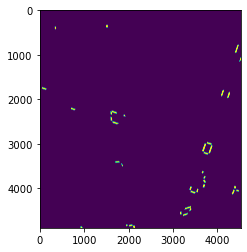

In [16]:
pyplot.imshow(labels)
pyplot.show()

In [17]:
# with rasterio.open(
#         'rasterized-results.tif', 'w',
#         driver='GTiff',
#         dtype=rasterio.uint8,
#         count=1,
#         width=dataset.width,
#         height=dataset.height,
#         transform=dataset.transform) as dst:
#     dst.write(image, indexes=1)

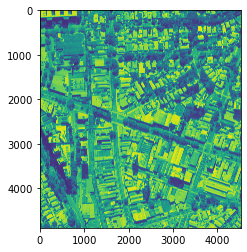

In [18]:
pyplot.imshow(dataset.read(1))
pyplot.show()

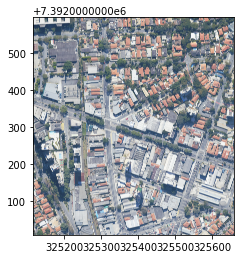

<AxesSubplot:>

In [19]:
show(dataset)

## Gerando mascaras de quadras

In [20]:
gdf_quadras = gpd.read_file('zip://downloads/SIRGAS_SHP_quadraMDSF.zip!/SIRGAS_SHP_quadraMDSF/SIRGAS_SHP_quadraMDSF.shp')

In [21]:
from shapely.geometry import box
gpd.GeoSeries(box(*dataset.bounds))

0    POLYGON ((325659.383 7392008.205, 325659.383 7...
dtype: geometry

In [22]:
quadras_scm = gpd.clip(gdf_quadras, gpd.GeoSeries(box(*dataset.bounds))).unary_union

In [23]:
# print(quadras_scm)

In [24]:
quadras = features.rasterize(
            ((g, 255) for g in quadras_scm),
            out_shape=dataset.shape,
            transform=dataset.transform)

In [25]:
quadras.shape, labels.shape, dataset.shape

((4893, 4522), (4893, 4522), (4893, 4522))

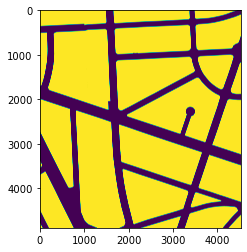

In [26]:
pyplot.imshow(quadras)

## Preparando as imagens

### Gerando GrayScale



In [27]:
grayscale = 0.2125 * dataset.read(1) + \
            0.7154 * dataset.read(2) + \
            0.0721 * dataset.read(3)

In [28]:
grayscale.astype('uint8')

array([[245, 245, 245, ..., 104,  91, 106],
       [227, 223, 220, ..., 115,  96,  83],
       [189, 192, 196, ..., 151, 111,  90],
       ...,
       [179, 183, 187, ...,  41,  45,  52],
       [180, 183, 188, ...,  50,  48,  69],
       [182, 184, 188, ...,  90,  70,  85]], dtype=uint8)

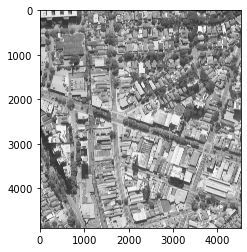

In [29]:
pyplot.imshow(grayscale.astype('uint8'), cmap='gray')

In [30]:
with rasterio.open(
        'tmp/grayscale-results.tif', 'w',
        driver='GTiff',
        dtype=rasterio.uint8,
        count=1,
        width=dataset.width,
        height=dataset.height,
        transform=dataset.transform) as dst:
    dst.write(grayscale.astype('uint8'), indexes=1)

### Gerando HOG e Local Binary Pattern (LBPH)

In [31]:
from skimage.feature import hog

In [32]:
fd, hog_image = hog(grayscale, orientations=8, visualize=True, 
                    pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1))

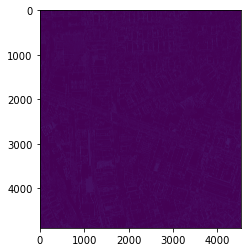

In [33]:
pyplot.imshow(hog_image)

In [34]:
from skimage.feature import local_binary_pattern

In [35]:
radius = 3
n_points = 8 * radius

In [36]:
lbp = local_binary_pattern(grayscale, n_points, radius)

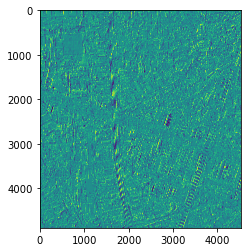

In [37]:
pyplot.imshow(lbp)

## Reescalonando

In [38]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [39]:
scaler = StandardScaler()

In [40]:
grayscale = scaler.fit_transform(grayscale)

In [41]:
scaler = MinMaxScaler(feature_range=(-1, 1))

In [42]:
hog_image = scaler.fit_transform(hog_image)

In [43]:
lbp = scaler.fit_transform(lbp)

## Gerando as lições 

Considera lição se a condiçao for:

* mais de 80% dos pixels dentro da lição da faixa de pedestre
* apenas de 5% ou menos dos pixels estiverem fora dentro da quadra viária
* 100% dos pixels dentro do SCM

### DAta Augmentation das lições das faixas de pedestre

* Rotate 0, 90, 180, 270 
* Cada rotate Flip H e V
* 16 possibilidades de Augmentation
* (Talvez um rotation a cada 15 graus, 6 possibilides, aumentando total para 96 possibilidades)

In [44]:
tamanho_janela = 24 # tamanho em pixels
sobreposicao_de_janelas = 16 # sobreposição das janelas em pixels

In [45]:
# grayscale = grayscale.astype('uint8')

In [46]:
import numpy as np

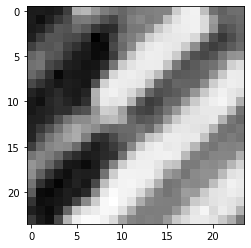

In [47]:
# 4864 920
pyplot.imshow(grayscale[4864:4864+tamanho_janela, 920:920+tamanho_janela], cmap='gray')

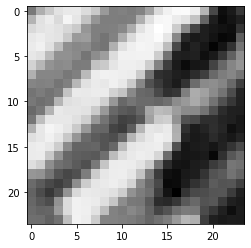

In [48]:
pyplot.imshow(np.flip(grayscale[4864:4864+tamanho_janela, 920:920+tamanho_janela]), cmap='gray')

In [49]:
# pyplot.imshow(np.flipud(grayscale[4864:4864+tamanho_janela, 920:920+tamanho_janela]), cmap='gray')
# pyplot.imshow(np.fliplr(grayscale[4864:4864+tamanho_janela, 920:920+tamanho_janela]), cmap='gray')

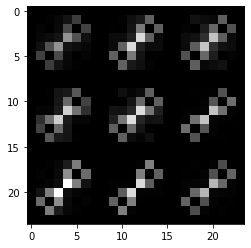

In [50]:
pyplot.imshow(hog_image[4864:4864+tamanho_janela, 920:920+tamanho_janela], cmap='gray')

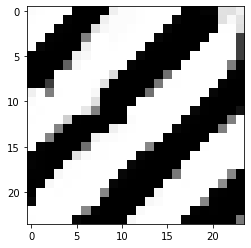

In [51]:
pyplot.imshow(lbp[4864:4864+tamanho_janela, 920:920+tamanho_janela], cmap='gray')

In [52]:
np.concatenate([grayscale[4864:4864+tamanho_janela, 920:920+tamanho_janela],
                hog_image[4864:4864+tamanho_janela, 920:920+tamanho_janela],
                lbp[4864:4864+tamanho_janela, 920:920+tamanho_janela]]).reshape(1, 72*24).shape

(1, 1728)

In [53]:
np.empty((1, 3 * (tamanho_janela ** 2)))

array([[ 6.91854086e-310,  6.91854086e-310,  4.65462054e-310, ...,
        -9.92188453e-001, -9.96094703e-001, -5.85946476e-002]])

In [58]:
rua = 0
faixa = 0
array_faixa, array_rua = [], [] 

df_treinamento = pd.DataFrame(columns=['faixa_de_pedestre'])


for i in np.arange(0, grayscale.shape[0] - tamanho_janela, tamanho_janela - sobreposicao_de_janelas):
    for j in np.arange(0, grayscale.shape[1] - tamanho_janela, tamanho_janela - sobreposicao_de_janelas):
        # Se mais de 80% dos pixels estiverem fora da quadra
        if np.count_nonzero(quadras[i:i+tamanho_janela, j:j+tamanho_janela] == 255) < 0.05 * (tamanho_janela ** 2):
            # print(i, j)
            # Se mais de 80% dos pixels estiverem dentro de um label de faixa de pedestre
            img_gray = grayscale[i:i+tamanho_janela, j:j+tamanho_janela]
            img_hog = hog_image[i:i+tamanho_janela, j:j+tamanho_janela]
            img_lbp = lbp[i:i+tamanho_janela, j:j+tamanho_janela]

            # Data Augmentation
            
            img = np.concatenate([
                img_gray,
                img_hog,
                img_lbp
            ]).reshape(1, 3 * (tamanho_janela ** 2))
            
            if np.count_nonzero(labels[i:i+tamanho_janela, j:j+tamanho_janela] == 255) > 0.80 * (tamanho_janela ** 2):
                faixa += 16
                

                for r in ['rotaciona 0', 'rotaciona 90', 'rotaciona 180', 'rotaciona 270']:
                    
                    # flip Up/Down

                    img_flipud = np.concatenate([
                        np.flipud(img_gray),
                        np.flipud(img_hog),
                        np.flipud(img_lbp)
                    ]).reshape(1, 3 * (tamanho_janela ** 2))

                    # flip Left/Right

                    img_fliplr = np.concatenate([
                        np.fliplr(img_gray),
                        np.fliplr(img_hog),
                        np.fliplr(img_lbp)
                    ]).reshape(1, 3 * (tamanho_janela ** 2))

                    # flip

                    img_flip = np.concatenate([
                        np.flip(img_gray),
                        np.flip(img_hog),
                        np.flip(img_lbp)
                    ]).reshape(1, 3 * (tamanho_janela ** 2))

                    for fl_img in (img, img_flipud, img_fliplr, img_flip):
                    # for fl_img in (img):
                        array_faixa.append(fl_img.reshape(1, 3 * (tamanho_janela ** 2)))


                    img_gray, img_hog, img_lbp = np.rot90(img_gray), np.rot90(img_hog), np.rot90(img_lbp)

            else:
                rua += 1
                array_rua.append(img.reshape(1, 3 * (tamanho_janela ** 2)))



print(f"{rua} ruas e {faixa} faixas")

783 ruas e 12528 faixas


In [56]:
img

'downloads/imagens/ORTO_3313-414_RGB_1000_v2.jp2'

In [ ]:
pd.DataFrame(np.array(array_faixa).reshape((12528, 1728)))

## Iterando sobre todos os SCMs e todas as licoes